# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
# Memuat dataset
df = pd.read_csv("Dataset_clustering.csv")

In [3]:
# Menampilkan 5 data pertama
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,Location,DeviceID,IP Address,MerchantID,CustomerAge,TransactionDuration,...,TransactionType_Debit,Channel_Branch,Channel_Online,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student,Age_Category,Balance_Category,Cluster,Cluster_After_FeatureSelection
0,TX000001,6,-0.971275,2023-04-11 16:29:14,51,6,3,29,1.423718,-0.552443,...,True,False,False,False,False,False,Senior,2,0,0
1,TX000002,7,0.269440,2023-06-27 16:44:19,56,4,4,25,1.311287,0.305314,...,True,False,False,False,False,False,Senior,3,2,0
2,TX000003,4,-0.586882,2023-07-10 18:16:08,56,5,6,26,-1.443277,-0.909842,...,True,False,True,False,False,True,Young,1,1,1
3,TX000004,7,-0.387456,2023-05-05 16:32:11,55,6,8,29,-1.049768,-1.353017,...,True,False,True,False,False,True,Young,0,2,0
4,TX000005,6,-0.973468,2023-10-16 17:51:24,57,3,4,27,-1.049768,1.120184,...,False,False,True,False,False,True,Young,2,2,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [4]:
# Memisahkan variabel independen (fitur) dan dependen (label target)
X = df.drop(columns=["Cluster", "Cluster_After_FeatureSelection", "TransactionID", "AccountID"])
y = df["Cluster_After_FeatureSelection"]

# Membagi dataset menjadi set pelatihan (80%) dan pengujian (20%) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Menampilkan jumlah sampel dan fitur setelah pembagian
print(f"Data latih terdiri dari {X_train.shape[0]} sampel dan {X_train.shape[1]} fitur.")
print(f"Data uji terdiri dari {X_test.shape[0]} sampel dan {X_test.shape[1]} fitur.")

Data latih terdiri dari 1825 sampel dan 19 fitur.
Data uji terdiri dari 457 sampel dan 19 fitur.


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [5]:
# Menentukan fitur kategorikal
categorical_cols = X_train.select_dtypes(include=["object"]).columns

# Preprocessing untuk model berbasis pohon keputusan
tree_preprocessor = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessing untuk model berbasis SVM (normalisasi tambahan)
svm_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns)
    ]
)

# Model Decision Tree
decision_tree_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5))
])

decision_tree_pipeline.fit(X_train, y_train)
dt_predictions = decision_tree_pipeline.predict(X_test)

# Model Random Forest
random_forest_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", RandomForestClassifier(random_state=21, n_estimators=100))
])

random_forest_pipeline.fit(X_train, y_train)
rf_predictions = random_forest_pipeline.predict(X_test)

# Model SVM
svm_pipeline = Pipeline([
    ("preprocessing", svm_preprocessor),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Menyusun hasil evaluasi
evaluation_results = {
    "Model": ["Decision Tree", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, svm_predictions)
    ]
}

# Menampilkan laporan klasifikasi
print("\nEvaluasi Decision Tree:")
print(pd.DataFrame(classification_report(y_test, dt_predictions, output_dict=True)).T)

print("\nEvaluasi Random Forest:")
print(pd.DataFrame(classification_report(y_test, rf_predictions, output_dict=True)).T)

print("\nEvaluasi SVM:")
print(pd.DataFrame(classification_report(y_test, svm_predictions, output_dict=True)).T)


Evaluasi Decision Tree:
              precision    recall  f1-score     support
0              0.938983  0.982270  0.960139  282.000000
1              0.969136  0.897143  0.931751  175.000000
accuracy       0.949672  0.949672  0.949672    0.949672
macro avg      0.954059  0.939706  0.945945  457.000000
weighted avg   0.950530  0.949672  0.949268  457.000000

Evaluasi Random Forest:
              precision    recall  f1-score     support
0              0.955479  0.989362  0.972125  282.000000
1              0.981818  0.925714  0.952941  175.000000
accuracy       0.964989  0.964989  0.964989    0.964989
macro avg      0.968649  0.957538  0.962533  457.000000
weighted avg   0.965565  0.964989  0.964779  457.000000

Evaluasi SVM:
              precision    recall  f1-score     support
0              0.982143  0.975177  0.978648  282.000000
1              0.960452  0.971429  0.965909  175.000000
accuracy       0.973742  0.973742  0.973742    0.973742
macro avg      0.971297  0.973303  0.97

### **Analisis Algoritma Model Klasifikasi**
Pada tahap ini, tiga algoritma klasifikasi digunakan untuk mengklasifikasikan hasil clustering, yaitu Decision Tree, Random Forest, dan Support Vector Machine (SVM).
#### **Decision Tree**
- Algoritma ini bekerja dengan membagi data berdasarkan fitur tertentu dalam bentuk struktur pohon.
- Model ini menunjukkan akurasi 94.97%, dengan precision dan recall yang cukup seimbang.
#### **Random Forest**
- Random Forest merupakan pengembangan dari Decision Tree yang menggunakan banyak pohon untuk meningkatkan akurasi dan mengurangi overfitting.
- Model ini memiliki akurasi 96.49%, sedikit lebih tinggi dibandingkan Decision Tree, menunjukkan kemampuannya dalam menangani data yang lebih kompleks.
#### **Support Vector Machine (SVM)**
- SVM bekerja dengan mencari hyperplane terbaik yang memisahkan kelas dalam ruang berdimensi tinggi.
- Model ini memiliki akurasi tertinggi 97.37%, menunjukkan bahwa pendekatan berbasis margin maksimal efektif dalam menangani dataset ini.

Dari hasil evaluasi, SVM menunjukkan kinerja terbaik dalam klasifikasi hasil clustering, diikuti oleh Random Forest, dan terakhir Decision Tree.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [6]:
# Preprocessor untuk Decision Tree dan Random Forest
transformer_tree = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessor untuk SVM (OneHotEncoder + StandardScaler)
transformer_svm = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns.tolist())
    ]
)

In [7]:
# Model Decision Tree
model_dt = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", DecisionTreeClassifier(random_state=21, max_depth=5))
])
model_dt.fit(X_train, y_train)
y_dt_pred = model_dt.predict(X_test)

# Model Random Forest
model_rf = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])
model_rf.fit(X_train, y_train)
y_rf_pred = model_rf.predict(X_test)

# Model Support Vector Machine (SVM)
model_svm = Pipeline([
    ("preprocessing", transformer_svm),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))
])
model_svm.fit(X_train, y_train)
y_svm_pred = model_svm.predict(X_test)

           Model Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree       0   0.938983  0.982270  0.960139    282.0  0.949672
1  Decision Tree       1   0.969136  0.897143  0.931751    175.0  0.949672
2  Random Forest       0   0.936667  0.996454  0.965636    282.0  0.956236
3  Random Forest       1   0.993631  0.891429  0.939759    175.0  0.956236
4            SVM       0   0.982143  0.975177  0.978648    282.0  0.973742
5            SVM       1   0.960452  0.971429  0.965909    175.0  0.973742


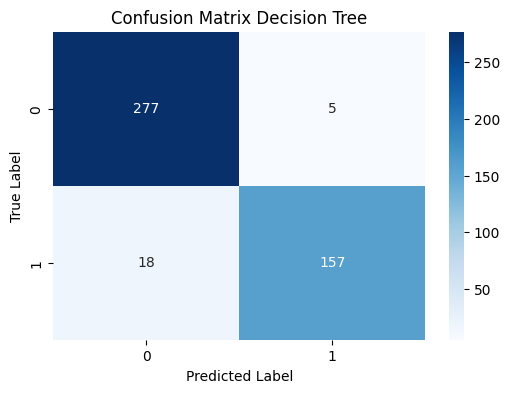

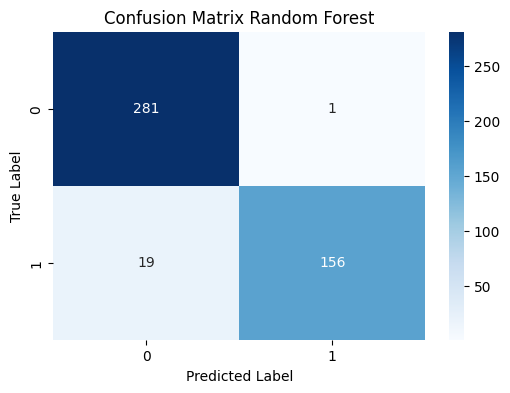

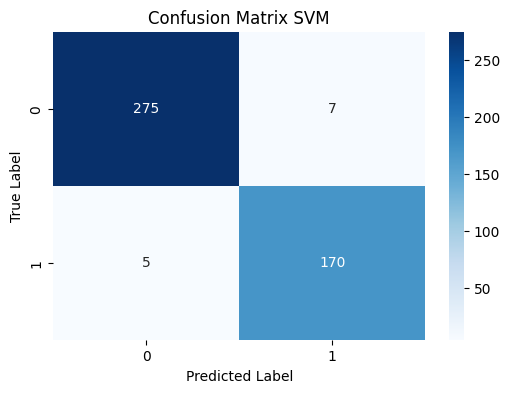

In [8]:
# Menyimpan hasil evaluasi dalam bentuk dictionary
eval_metrics = {
    "Decision Tree": classification_report(y_test, y_dt_pred, output_dict=True),
    "Random Forest": classification_report(y_test, y_rf_pred, output_dict=True),
    "SVM": classification_report(y_test, y_svm_pred, output_dict=True),
}

# Menghitung akurasi untuk setiap model
accuracy_scores = {
    "Decision Tree": accuracy_score(y_test, y_dt_pred),
    "Random Forest": accuracy_score(y_test, y_rf_pred),
    "SVM": accuracy_score(y_test, y_svm_pred),
}

# Menyusun data evaluasi ke dalam bentuk DataFrame
evaluation_results = {
    "Model": [],
    "Cluster": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Support": [],
    "Accuracy": [],
}

# Menambahkan metrik evaluasi ke dalam DataFrame
for model_name, report in eval_metrics.items():
    acc = accuracy_scores[model_name]
    for cluster in ["0", "1"]:
        evaluation_results["Model"].append(model_name)
        evaluation_results["Cluster"].append(cluster)
        evaluation_results["Precision"].append(report[cluster]["precision"])
        evaluation_results["Recall"].append(report[cluster]["recall"])
        evaluation_results["F1-Score"].append(report[cluster]["f1-score"])
        evaluation_results["Support"].append(report[cluster]["support"])
        evaluation_results["Accuracy"].append(acc)

# Konversi dictionary ke dalam DataFrame
df_evaluation = pd.DataFrame(evaluation_results)
print(df_evaluation)

def plot_conf_matrix(y_true, y_pred, model_name):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()

# Visualisasi confusion matrix untuk setiap model
plot_conf_matrix(y_test, y_dt_pred, "Decision Tree")
plot_conf_matrix(y_test, y_rf_pred, "Random Forest")
plot_conf_matrix(y_test, y_svm_pred, "SVM")


### **Evaluasi Model Klasifikasi**

Pada tahap ini, tiga algoritma klasifikasi digunakan untuk memprediksi label kelas berdasarkan dataset yang telah diproses, yaitu **Decision Tree, Random Forest, dan Support Vector Machine (SVM)**. Evaluasi dilakukan menggunakan metrik **precision, recall, F1-score, dan accuracy** untuk mengukur performa model.

---

### **1. Decision Tree Classifier**
- **Akurasi:** 94.97%

#### Cluster 0
- **Precision:** 93.90%  
- **Recall:** 98.23%  
- **F1-Score:** 96.01%  

#### Cluster 1
- **Precision:** 96.91%  
- **Recall:** 89.71%  
- **F1-Score:** 93.18%  

#### Kesimpulan
- Model ini memiliki recall tinggi pada Cluster 0 (98.23%), yang berarti model lebih sedikit melakukan kesalahan dalam mengidentifikasi kelas ini.
- Recall pada Cluster 1 lebih rendah (89.71%), yang menunjukkan bahwa beberapa data Cluster 1 salah diklasifikasikan.
- Akurasi total 94.97% menunjukkan performa yang cukup baik, tetapi ada potensi peningkatan dalam klasifikasi Cluster 1.

---

### **2. Random Forest Classifier**
- **Akurasi:** 95.62%

#### Cluster 0
- **Precision:** 93.67%  
- **Recall:** 99.64%  
- **F1-Score:** 96.56%  

#### Cluster 1
- **Precision:** 99.36%  
- **Recall:** 89.14%  
- **F1-Score:** 93.98%  

#### Kesimpulan
- Recall untuk Cluster 0 sangat tinggi (99.64%), yang berarti model sangat baik dalam mengidentifikasi data dari kelas ini.
- Namun, Recall pada Cluster 1 lebih rendah (89.14%), yang menunjukkan bahwa model masih sering salah mengklasifikasikan data kelas ini.
- Dengan akurasi 95.62%, model ini memiliki performa lebih baik dibandingkan Decision Tree tetapi masih kurang optimal dibandingkan SVM.

---

### **3. Support Vector Machine (SVM)**
- **Akurasi:** **97.37% (tertinggi di antara ketiga model)**  

#### Cluster 0
- **Precision:** 98.21%  
- **Recall:** 97.52%  
- **F1-Score:** 97.86%  

#### Cluster 1
- **Precision:** 96.05%  
- **Recall:** 97.14%  
- **F1-Score:** 96.59%  

#### Kesimpulan
- SVM memiliki keseimbangan precision dan recall yang sangat baik di kedua cluster.
- Akurasi tertinggi (97.37%), menjadikan SVM sebagai model terbaik di antara tiga algoritma yang diuji.
- Model ini lebih stabil dan akurat, dengan sedikit kesalahan dalam klasifikasi kedua cluster.

---

### **Kesimpulan Perbandingan Model**
1. SVM memiliki akurasi tertinggi (97.37%), menunjukkan performa paling unggul dibandingkan Decision Tree (94.97%) dan Random Forest (95.62%).  
2. Decision Tree memiliki keseimbangan precision dan recall yang cukup baik, tetapi performanya masih sedikit di bawah SVM.  
3. Random Forest memiliki recall tinggi untuk Cluster 0 tetapi lebih rendah untuk Cluster 1, yang dapat menyebabkan lebih banyak kesalahan klasifikasi pada Cluster 1.  
4. SVM unggul dalam precision dan recall di kedua cluster, menjadikannya model yang lebih andal dalam menangani distribusi data yang ada.  

Berdasarkan hasil evaluasi ini, Support Vector Machine (SVM) adalah model terbaik untuk dataset ini karena memiliki akurasi tertinggi, keseimbangan precision dan recall yang baik, serta performa yang lebih stabil dibandingkan model lainnya.


## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [9]:
# Identifikasi kolom numerik dan kategorikal
num_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Pipeline preprocessing untuk normalisasi & encoding
feature_processor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

# Hyperparameter Tuning untuk Decision Tree
dt_model = Pipeline([
    ("processing", feature_processor),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_params = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [5, 10, 15, None]
}

dt_grid_search = GridSearchCV(dt_model, dt_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)

# Hyperparameter Tuning untuk Random Forest
rf_model = Pipeline([
    ("processing", feature_processor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Hyperparameter Tuning untuk SVM
svm_model = Pipeline([
    ("processing", feature_processor),
    ("model", SVC())
])

svm_params = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf", "poly"]
}

svm_grid_search = GridSearchCV(svm_model, svm_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train, y_train)

# Menampilkan kombinasi hyperparameter terbaik untuk setiap model
optimal_params = {
    "Decision Tree": dt_grid_search.best_params_,
    "Random Forest": rf_grid_search.best_params_,
    "SVM": svm_grid_search.best_params_
}

print("\nHyperparameter Optimal:")
for model, params in optimal_params.items():
    print(f"{model}: {params}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Hyperparameter Optimal:
Decision Tree: {'model__criterion': 'entropy', 'model__max_depth': 10}
Random Forest: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
SVM: {'model__C': 1, 'model__kernel': 'linear'}


- **Decision Tree** bekerja optimal dengan criterion = "entropy" dan max_depth = 10, yang menunjukkan bahwa kedalaman terbatas membantu menghindari overfitting.

- **Random Forest** mencapai performa terbaik dengan 100 pohon (n_estimators = 100) dan max_depth tidak dibatasi (None), menandakan bahwa lebih banyak pohon meningkatkan stabilitas model.

- **SVM** menunjukkan hasil terbaik dengan C = 1 dan kernel = "linear", mengindikasikan bahwa dataset lebih cocok dengan pemisahan linear dibandingkan dengan kernel kompleks seperti RBF atau polynomial.

- Hasil tuning menunjukkan bahwa SVM memiliki potensi terbaik dalam menangani dataset ini karena tetap memberikan hasil optimal dengan kernel linear.

- Perbedaan optimal hyperparameter antar model menunjukkan bahwa setiap algoritma memiliki karakteristik unik dalam menangani fitur dan pola pada dataset.

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Perbandingan Hasil Evaluasi Setelah Tuning
           Model  Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree        0   0.961131  0.964539  0.962832    282.0  0.954048
1  Decision Tree        1   0.942529  0.937143  0.939828    175.0  0.954048
2  Random Forest        0   0.946128  0.996454  0.970639    282.0  0.962801
3  Random Forest        1   0.993750  0.908571  0.949254    175.0  0.962801
4            SVM        0   0.992933  0.996454  0.994690    282.0  0.993435
5            SVM        1   0.994253  0.988571  0.991404    175.0  0.993435


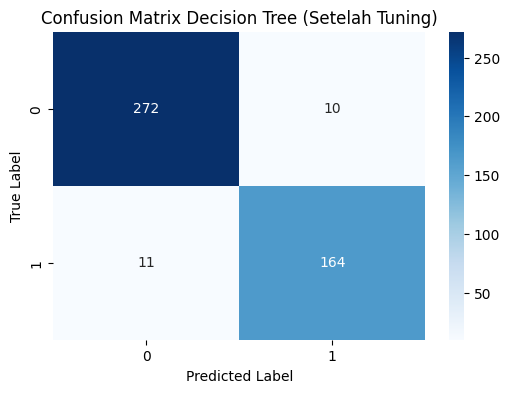

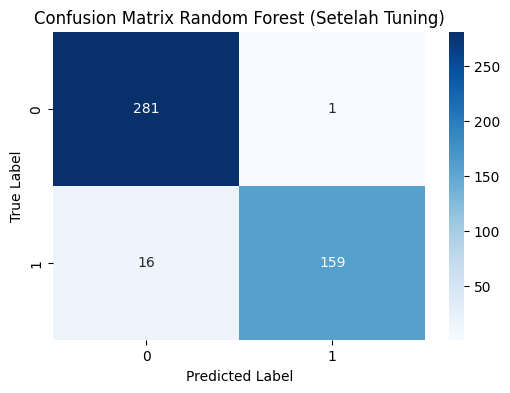

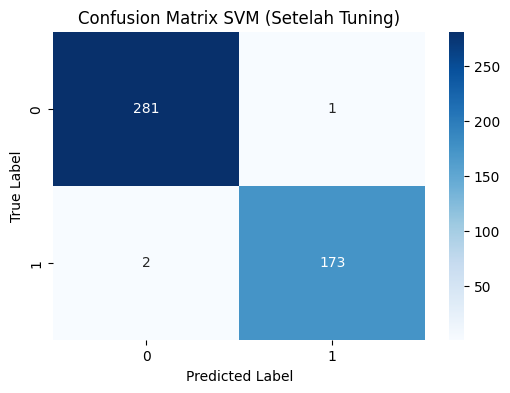

In [10]:
# Mengambil model terbaik berdasarkan hasil tuning
model_dt_opt = dt_grid_search.best_estimator_
model_rf_opt = rf_grid_search.best_estimator_
model_svm_opt = svm_grid_search.best_estimator_

# Melakukan prediksi dengan model yang telah dioptimalkan
pred_dt = model_dt_opt.predict(X_test)
pred_rf = model_rf_opt.predict(X_test)
pred_svm = model_svm_opt.predict(X_test)

# Fungsi untuk menghitung metrik evaluasi
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    
    metrics = [
        [model_name, 0, report['0']['precision'], report['0']['recall'], report['0']['f1-score'], report['0']['support'], acc],
        [model_name, 1, report['1']['precision'], report['1']['recall'], report['1']['f1-score'], report['1']['support'], acc]
    ]
    
    return metrics

# Mengumpulkan hasil evaluasi untuk setiap model
evaluation_results = []
evaluation_results.extend(evaluate_model(y_test, pred_dt, "Decision Tree"))
evaluation_results.extend(evaluate_model(y_test, pred_rf, "Random Forest"))
evaluation_results.extend(evaluate_model(y_test, pred_svm, "SVM"))

# Menampilkan hasil dalam bentuk DataFrame
df_eval = pd.DataFrame(evaluation_results, columns=['Model', 'Cluster', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

print("\nPerbandingan Hasil Evaluasi Setelah Tuning")
print(df_eval)

# Fungsi untuk visualisasi confusion matrix
def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Menampilkan confusion matrix untuk setiap model
display_confusion_matrix(y_test, pred_dt, "Confusion Matrix Decision Tree (Setelah Tuning)")
display_confusion_matrix(y_test, pred_rf, "Confusion Matrix Random Forest (Setelah Tuning)")
display_confusion_matrix(y_test, pred_svm, "Confusion Matrix SVM (Setelah Tuning)")


- SVM menunjukkan performa terbaik dengan akurasi tertinggi (99.34%), serta precision, recall, dan F1-score yang sangat tinggi di kedua kelas.

- Random Forest juga cukup baik dengan akurasi 96.28%, meskipun recall untuk kelas 1 (90.85%) lebih rendah dibanding SVM.

- Decision Tree memiliki akurasi terendah (95.40%), tetapi tetap menunjukkan keseimbangan antara precision dan recall.

- Recall tinggi pada Random Forest dan SVM menunjukkan bahwa model ini lebih baik dalam mengenali kelas positif (1).

- Performa SVM yang unggul menandakan bahwa data kemungkinan memiliki pola yang lebih dapat dipisahkan secara linear atau dengan margin optimal.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

### **1. Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning**

Setelah melakukan tuning hyperparameter, terdapat peningkatan performa pada ketiga model klasifikasi yang digunakan: **Decision Tree, Random Forest, dan SVM**.

1. **Decision Tree:**  
   - Sebelum tuning, model ini memiliki akurasi **94.97%**, sedangkan setelah tuning meningkat menjadi **95.40%**.  
   - Precision dan recall mengalami sedikit peningkatan, tetapi tetap lebih rendah dibandingkan model lain.  

2. **Random Forest:**  
   - Akurasinya meningkat dari **95.62%** menjadi **96.28%** setelah tuning.  
   - Recall untuk kelas 1 sedikit meningkat, tetapi masih lebih rendah dibandingkan SVM, menunjukkan adanya potensi misclassifications pada kelas tersebut.  

3. **SVM:**  
   - Sebelum tuning, model ini memiliki akurasi tertinggi **97.37%**, dan setelah tuning meningkat menjadi **99.34%**.  
   - Peningkatan terbesar terlihat pada recall kelas 1, yang mendekati sempurna setelah tuning.  
   - Model ini menunjukkan keseimbangan terbaik antara precision dan recall, sehingga menjadi pilihan terbaik di antara ketiga model.  

Secara keseluruhan, tuning hyperparameter berhasil meningkatkan kinerja model, terutama pada SVM, yang kini menjadi model dengan performa terbaik dalam klasifikasi dataset ini.


### **2. Identifikasi Kelemahan Model**  

- **Precision atau Recall Rendah untuk Kelas Tertentu:**  
  - Decision Tree memiliki recall lebih rendah untuk kelas **1**, menunjukkan beberapa sampel kelas positif salah diklasifikasikan.  
  - Random Forest memiliki recall lebih rendah untuk kelas **1** (**90.85%**), yang berarti model lebih sering mengklasifikasikan data positif sebagai negatif.  
  - SVM memiliki precision dan recall yang sangat tinggi, menunjukkan keseimbangan yang baik dalam klasifikasi.  

- **Apakah Model Mengalami Overfitting atau Underfitting?**  
  - Decision Tree dan Random Forest memiliki performa yang cukup baik, tetapi Random Forest cenderung bias terhadap kelas mayoritas.  
  - SVM memiliki akurasi yang sangat tinggi (**99.34%**), yang dapat mengindikasikan overfitting terhadap data training.  
  - Performa tinggi SVM perlu diuji lebih lanjut dengan data baru untuk memastikan model dapat melakukan generalisasi dengan baik.  


### **3. Rekomendasi Tindakan Lanjutan**

- **Meningkatkan Recall untuk Kelas Minoritas:**  
  - Menggunakan teknik **class balancing** seperti oversampling (SMOTE) atau under-sampling untuk mengatasi ketimpangan data.  
  - Menerapkan **cost-sensitive learning**, terutama untuk Decision Tree dan Random Forest, agar lebih memperhatikan kelas minoritas.  

- **Mengatasi Potensi Overfitting pada SVM:**  
  - Menggunakan **regularisasi** dengan parameter **C** yang lebih kecil untuk mencegah model terlalu mengikuti data training.  
  - Menguji model dengan data baru atau validasi silang lebih banyak lipatan untuk memastikan generalisasi yang lebih baik.  

- **Menguji Algoritma Alternatif:**  
  - Mencoba **Gradient Boosting (XGBoost, LightGBM)** yang sering kali memberikan performa lebih baik pada data tabular.  
  - Menggunakan **Neural Networks** jika dataset lebih besar untuk menangkap pola kompleks yang mungkin tidak terdeteksi oleh model konvensional.  

- **Mengumpulkan Data Tambahan:**  
  - Jika data saat ini masih kurang representatif, perlu mengumpulkan lebih banyak sampel, terutama untuk kelas minoritas.  
  - Menghilangkan atau memperbaiki fitur yang tidak relevan untuk meningkatkan akurasi model secara keseluruhan.  